## Install Libraries

In [ ]:
pip install transformers datasets torch pandas numpy scikit-learn matplotlib seaborn

## Load Dataset

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from datasets import Dataset

# Load the dataset
df = pd.read_csv("stock_data.csv")

## Data Preprocessing

In [ ]:
# Preprocess the tweets
df.dropna(subset=["text", "sentiment"], inplace=True)

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Remove special characters
    return text.lower().strip()

df["cleaned_tweet"] = df["text"].apply(clean_text)

# Convert sentiment labels to binary (0 = negative, 1 = positive)
# Instead of directly assigning, handle -1 labels:
df["label"] = df["sentiment"].apply(lambda x: 0 if x == -1 else x)  # Map -1 to 0 (negative)

# Split into training and testing data
train_df, test_df = train_test_split(df[['cleaned_tweet', 'label']], test_size=0.2, random_state=42)

## Load & Train Model

In [ ]:
from transformers import TrainingArguments, BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification
from datasets import Dataset

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize
def tokenize(batch):
    return tokenizer(batch["cleaned_tweet"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds)}

# Optimized Training Arguments
training_args = TrainingArguments(
    output_dir="./finbert_results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,  # Smaller LR stabilizes training
    logging_steps=64,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()
# apiKey: ce3d6f3ca65d9f1db3ed449355762fdd88f2eb81

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

Map:   0%|          | 0/4632 [00:00<?, ? examples/s]

Map:   0%|          | 0/1159 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
64,0.669700
128,0.637400
192,0.549800
256,0.536000
320,0.540600
384,0.521000
448,0.511300
512,0.485600
576,0.472900
640,0.392700


## Model Prediction

In [ ]:
# Make predictions on the test dataset
def predict_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    output = model(**tokens)
    sentiment = torch.argmax(output.logits, dim=1).item()
    return sentiment

# Add predicted sentiments to the test dataset
test_df["predicted_sentiment"] = test_df["cleaned_tweet"].apply(predict_sentiment)

# Reverse the mapping to see the labels
inv_label_map = {0: "negative", 1: "positive"}
test_df["predicted_sentiment_label"] = test_df["predicted_sentiment"].map(inv_label_map)

# Calculate accuracy and classification report
accuracy = accuracy_score(test_df['label'].iloc[:len(test_df)].tolist(), test_df["predicted_sentiment"].iloc[:len(test_df)].tolist())
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(test_df['label'].iloc[:len(test_df)].tolist(), test_df["predicted_sentiment"].iloc[:len(test_df)].tolist()))

Accuracy: 79.98%
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       427
           1       0.82      0.87      0.85       732

    accuracy                           0.80      1159
   macro avg       0.79      0.78      0.78      1159
weighted avg       0.80      0.80      0.80      1159



## Result

<ipython-input-8-905c4f108124>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


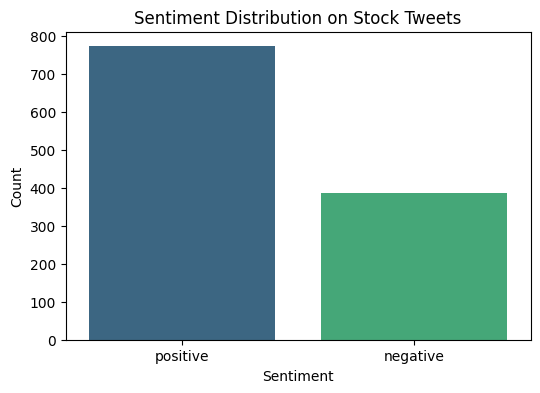

In [ ]:
# Visualization of sentiment distribution
sentiment_counts = test_df["predicted_sentiment_label"].value_counts()

# Plot sentiment distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Sentiment Distribution on Stock Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()
